<a href="https://colab.research.google.com/github/kavyajeetbora/end_to_end_gee_with_python/blob/master/Development/District-Builtup-Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

In [20]:
# Define the time range.
start_date = '1990-01-01'
end_date = '2024-12-31'

# Load the GAUL dataset for second-level administrative units
gaul_dataset = ee.FeatureCollection('FAO/GAUL/2015/level2')
# Filter the dataset to get the boundary of Goa
boundary = gaul_dataset.filter(ee.Filter.eq('ADM1_NAME', 'Goa'))
boundary.size()

## Merge the landsat image collection


- We will merge the landsat images from landsat 5 to landsat 9.
- We will filter the image collection by cloud cover, we want only clean images
- Also print the starting date and ending date of the available image collections

Which images to consider for cloud free images ?

Recommendation:
1. For General Land Cover Mapping and Long-Term Monitoring: Use the Median Composite method to ensure consistent and robust results, especially in areas with frequent cloud cover.
2. For Time-Series Analysis and Short-Term Changes: Use Zero Cloud Cover Images to maintain temporal precision and clarity.

In [27]:
# Function to calculate NDBI for Landsat 7 and 8
def calculate_ndbi_landsat7(image):
    # Select the NIR and SWIR bands
    nir = image.select('SR_B4')
    swir = image.select('SR_B5')

    # Calculate NDBI
    ndbi = swir.subtract(nir).divide(swir.add(nir)).rename('NDBI')

    # Copy properties from the original image
    ndbi = ndbi.copyProperties(image)

    return ndbi

# Function to calculate NDBI for Landsat 8 and 9
def calculate_ndbi_landsat8(image):
    # Select the NIR and SWIR bands
    nir = image.select('SR_B5')
    swir = image.select('SR_B6')

    # Calculate NDBI
    ndbi = swir.subtract(nir).divide(swir.add(nir)).rename('NDBI')

    # Copy properties from the original image
    ndbi = ndbi.copyProperties(image)

    return ndbi

# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

In [28]:
%%time
# Load the Landsat image collections.
landsat_collections = [
    "LANDSAT/LT05/C02/T1_L2",  # Landsat 5
    "LANDSAT/LE07/C02/T1_L2",  # Landsat 7
    'LANDSAT/LC08/C02/T1_L2',  # Landsat 8
    'LANDSAT/LC09/C02/T1_L2'   # Landsat 9
]

landsat_images = ee.ImageCollection([])
for collection in landsat_collections:

    image_collection = ee.ImageCollection(collection).filterDate(start_date, end_date)\
        .filterBounds(boundary)\
        .filter(ee.Filter.lt("CLOUD_COVER", 20))  ## images with less than 5% cloud clover

    # Map the function to the image collection
    scaled_image_collection = image_collection.map(apply_scale_factors)

    ## Calculate the index: NDBI:
    if "LT05" in collection or "LE07" in collection:
        new_collection = scaled_image_collection.map(calculate_ndbi_landsat7)
    elif "LC08" in collection or "LC09" in collection:
        new_collection = scaled_image_collection.map(calculate_ndbi_landsat8)

    landsat_images = landsat_images.merge(new_collection)


# Print the number of images in the combined Landsat collection.
print('Number of images in Landsat collection:', landsat_images.size().getInfo())

first_image = landsat_images.sort('system:time_start', True).first()
last_image = landsat_images.sort('system:time_start', False).first()

date1 = first_image.get('DATE_ACQUIRED').getInfo()
date2 = last_image.get('DATE_ACQUIRED').getInfo()

print(f"Images collection are from date: {date1} to {date2}")

Number of images in Landsat collection: 1361
Images collection are from date: 1990-02-07 to 1990-02-07
CPU times: user 86.8 ms, sys: 7.89 ms, total: 94.7 ms
Wall time: 8.04 s


In [30]:
landsat_images.first()

In [32]:
landsat_images.first().get('system:time_start')

## Get the number of images for each year

In [29]:
# Function to get the year from the image date
def get_year(image):
    return ee.Date(image.get('system:time_start')).get('year')

# Map the function over the image collection to get the list of years
years = landsat_images.map(lambda image: image.set('year', get_year(image)))

# Reduce the collection by year to count the number of images per year
year_counts = years.aggregate_histogram('year')

# Print the number of images for each year
print('Number of images for each year:', year_counts.getInfo())

EEException: Collection.reduceColumns: Error in map(ID=null):
Date: Parameter 'value' is required.

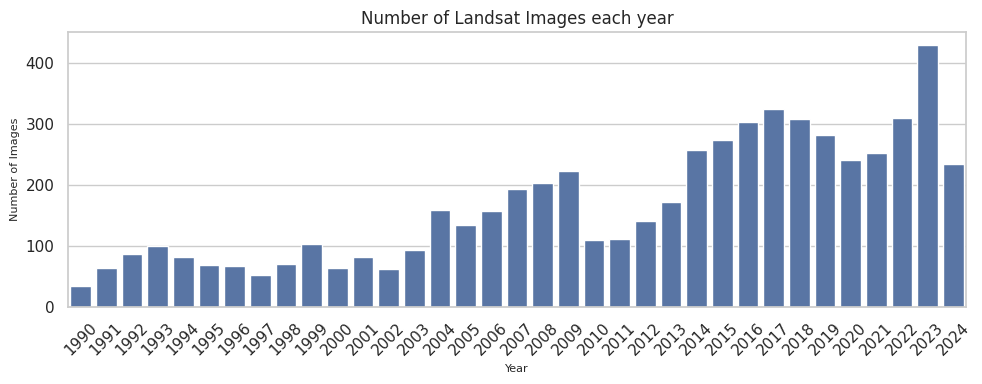

In [82]:
# Function to plot a bar plot from a dictionary
def plot_bar_from_dict(data_dict):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(list(data_dict.items()), columns=['Category', 'Value'])

    # Set the style of the plot
    sns.set(style="whitegrid")

    # Create the bar plot
    plt.figure(figsize=(10, 4))
    bar_plot = sns.barplot(x='Category', y='Value', data=df)

    # Add titles and labels
    bar_plot.set_title('Number of Landsat Images each year', fontsize=12)
    bar_plot.set_xlabel('Year', fontsize=8)
    bar_plot.set_ylabel('Number of Images', fontsize=8)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_bar_from_dict(year_counts.getInfo())

## Calculating the indices

## Find the yearly composites


- We will find the median composites for each year to get cloud free images
- we will determine this for each year

In [83]:
def get_yearly_composites(image_collection):

    yearly_composites = []
    for year in year_counts.getInfo().keys():
        start_date = ee.Date.fromYMD(int(year), 1, 1)
        end_date = ee.Date.fromYMD(int(year) + 1, 1, 1)

        img_col = image_collection.filterDate(start_date,end_date)

        first_image = img_col.first()

        median_composite = img_col.median().set('year', year) #.copyProperties(first_image)
        yearly_composites.append(median_composite)

    yearly_composites = ee.ImageCollection.fromImages(yearly_composites)
    return yearly_composites

yearly_composites = get_yearly_composites(scaled_landsat_images)

# Print the number of images in the yearly image collection
print('Number of images in yearly image collection:', yearly_composites.size().getInfo())

Number of images in yearly image collection: 35


## Visualizing the results

In [91]:
year = 2020
image = yearly_composites.filter(ee.Filter.eq('year', str(year))).first()
image

In [89]:
year = 2020
image = yearly_composites.filter(ee.Filter.eq('year', str(year))).first()

# Create a map and display the first image
Map = geemap.Map()
Map.centerObject(boundary, 10)

visualization = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'], # Use red, green, and blue bands
    'min': 0.0,
    'max': 0.3,
}
title = f"Year: {image.get('year').getInfo()}"

Map.addLayer(image.clip(boundary), visualization, title)
Map

Map(center=[14.694595869373765, 76.16768731861939], controls=(WidgetControl(options=['position', 'transparent_…

In [86]:
# Export the NDBI image to a GeoTIFF file
export_task = ee.batch.Export.image.toDrive(
    image=first_image,
    description='NDBI_Image_Export-2',
    folder='projects/gee_exports',
    fileNamePrefix='NDBI_Image-2',
    scale=30,
    region=boundary,
    fileFormat='GeoTIFF'
)

# Start the export task
export_task.start()